### Analyze station time
Instead of binning times, I try to group station time sequence by time approximity. This should be more natural and make more sense than `pd.qcut`. 
**But I don't see any significantly good distributions.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc 
import tqdm
import os
from matplotlib.backends.backend_pdf import PdfPages

% matplotlib inline

In [2]:
# Obtain all labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])
df = pd.read_csv('data/train_date.csv.zip', index_col=0)
df = df.join(response)

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
del response
gc.collect()

n_parts, n_columns = df.shape
n_columns -= 1
print(n_parts, n_columns)

1183747 1156


In [4]:
# stations and features in each station
stations = list(set([f.split('_')[1] for f in df.columns.tolist() if f!='Response']))

station_features = {s: [f for f in df.columns.tolist() if s in f] for s in stations }

In [5]:
# Calculate samples in each feature, if there is any station that every or almost every part flows by?
columns = df.columns.tolist()
feature_samples = {}
for col in tqdm.tqdm_notebook(columns):
    feature_samples[col] = len(df.loc[df[col].notna(), col])

feature_samples = pd.Series(feature_samples)
feature_samples.sort_values(ascending=False, inplace=True)
feature_samples.drop('Response', inplace=True)

feature_samples = feature_samples.reset_index()
feature_samples.columns = ['feature', 'count']
fs = feature_samples.copy()
fs['station'] = feature_samples['feature'].apply(lambda x: x.split('_')[1])

station_samples = fs.groupby('station')['count'].max().sort_values(ascending=False)

In [6]:
station_time = {}
for s in tqdm.tqdm_notebook(stations):
    station_time[s+'_start'] = df[station_features[s]].min(axis=1)
    station_time[s+'_end'] = df[station_features[s]].max(axis=1)
    station_time[s+'_duration'] = station_time[s+'_end'] - station_time[s+'_start']

In [7]:
x = pd.DataFrame(station_time)
x = x.join(df.Response)

In [12]:
a = x[['S30_start', 'Response']].copy()
a.dropna(axis=0, inplace=True)

b = a.groupby('S30_start').Response.agg(['mean', 'sum', 'count'])
b.columns = ['error_rate', 'error_sum', 'n']
b.sort_index(inplace=True)
t = b.index.values
c = b.groupby('n')['error_sum'].agg(['mean', 'sum', 'count'])
c['mean'] = c['mean']/c.index
c['confidence_interval'] = 1.96 * np.sqrt(c['mean'] * (1-c['mean']) / c['count'])
c['mean_low'] = c['mean'] - c['confidence_interval']
c['mean_high'] = c['mean'] + c['confidence_interval']

N = 25
plt.bar(c.index[:N], c['mean'][:N], yerr=c['confidence_interval'][:N])
plt.plot([-1, N+0.5], [0.0058, 0.0058], color='tab:red', label='average error rate')

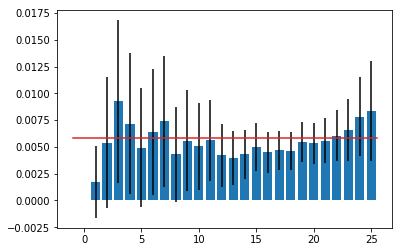

In [72]:
col = 'S30_end'
a = x[[col, 'Response']].copy()
a.dropna(axis=0, inplace=True)

b = a.groupby(col).Response.agg(['mean', 'sum', 'count'])
b.columns = ['error_rate', 'error_sum', 'n']
b.sort_index(inplace=True)
t = b.index.values
c = b.groupby('n')['error_sum'].agg(['mean', 'sum', 'count'])
c['mean'] = c['mean']/c.index
c['confidence_interval'] = 1.96 * np.sqrt(c['mean'] * (1-c['mean']) / c['count'])
c['mean_low'] = c['mean'] - c['confidence_interval']
c['mean_high'] = c['mean'] + c['confidence_interval']

N = 25
plt.bar(c.index[:N], c['mean'][:N], yerr=c['confidence_interval'][:N])
plt.plot([-1, N+0.5], [0.0058, 0.0058], color='tab:red', label='average error rate')

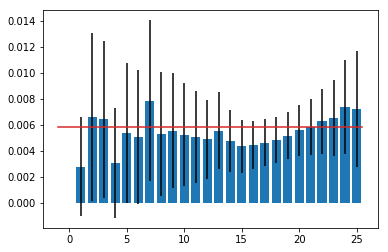

In [74]:
col = 'S29_end'
a = x[[col, 'Response']].copy()
a.dropna(axis=0, inplace=True)

b = a.groupby(col).Response.agg(['mean', 'sum', 'count'])
b.columns = ['error_rate', 'error_sum', 'n']
b.sort_index(inplace=True)
t = b.index.values
c = b.groupby('n')['error_sum'].agg(['mean', 'sum', 'count'])
c['mean'] = c['mean']/c.index
c['confidence_interval'] = 1.96 * np.sqrt(c['mean'] * (1-c['mean']) / c['count'])
c['mean_low'] = c['mean'] - c['confidence_interval']
c['mean_high'] = c['mean'] + c['confidence_interval']

N = 25
plt.bar(c.index[:N], c['mean'][:N], yerr=c['confidence_interval'][:N])
plt.plot([-1, N+0.5], [0.0058, 0.0058], color='tab:red', label='average error rate')